# Исследование автоэнкодера для снижения размерности

Загрузка необходимых библиотек

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn import datasets
import sys
import matplotlib.pyplot as plt
import numpy as np

Загрузка датасета Iris

In [29]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Поиск перебором наилучшей архитектуры автоэнкодера

In [30]:
best_mse = sys.float_info.max

for hidden_neurons in range(2, 31):
    model = MLPRegressor(
        hidden_layer_sizes=(hidden_neurons, 2, hidden_neurons),
        max_iter=5000, shuffle=False, random_state=30,
        activation='logistic', solver='lbfgs')
    model.fit(X_train, X_train)
    X_predicted = model.predict(X_test)
    mse = ((X_test - X_predicted) ** 2).mean(axis=None)

    if mse < best_mse:
        best_mse = mse
        print('Наименьшая ошибка при %d нейронах в скрытом слое. Ошибка %.3f' % (hidden_neurons, mse))

Наименьшая ошибка при 2 нейронах в скрытом слое. Ошибка 0.070
Наименьшая ошибка при 3 нейронах в скрытом слое. Ошибка 0.050
Наименьшая ошибка при 5 нейронах в скрытом слое. Ошибка 0.021


Создание нейронной сети с архитектурой автоэнкодера и её обучение

In [31]:
model = MLPRegressor(
    hidden_layer_sizes=(5, 2, 5),
    max_iter=50000, shuffle=False, random_state=30,
    activation='logistic', solver='lbfgs')

# модель обучается на тренировочной выборке
model.fit(X_train, X_train)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=50000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=30,
       shuffle=False, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Проверка качества обученной нейронной сети. Для этого с помощью обученной на тренировочных данных модели предсказываем отклики для тестовых данных и сравниваем с эталоном (красные точки - эталонные данные, синие - предсказание обученной модели).

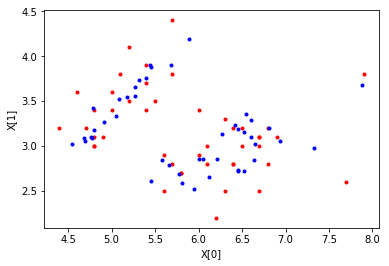

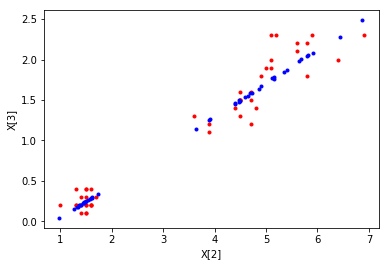

In [32]:
# прогноз с помощью обученного автоэнкодера для тестовых данных
X_predicted = model.predict(X_test)

# признаки 0 и 1
plt.plot(X_test[:,0], X_test[:,1], 'r.')
plt.plot(X_predicted[:,0], X_predicted[:,1], 'b.')
plt.xlabel('X[0]')
plt.ylabel('X[1]')
plt.show()

# признаки 2 и 3
plt.plot(X_test[:,2], X_test[:,3], 'r.')
plt.plot(X_predicted[:,2], X_predicted[:,3], 'b.')
plt.xlabel('X[2]')
plt.ylabel('X[3]')
plt.show()

Применение обученной модели для снижения размерности с 4 признаков до 2 признаков. Нарисуем на графике точки всех трёх классов.

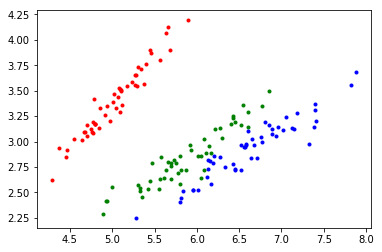

In [33]:
# запомним коэффициенты из обученной модели
theta1 = model.coefs_[0]
theta2 = model.coefs_[1]

# создадим и фиктивно обучим новую модель (авторегрессор), чтобы сформировать нужную внутреннюю архитектуру
model_ae = MLPRegressor(hidden_layer_sizes=(5), max_iter=2000, shuffle=False)
model_ae.fit(X, X[:,:2])

# присвоим коэффициенты от ранее обученной модели
model_ae.coefs_[0] = theta1
model_ae.coefs_[1] = theta2

# выполним предсказание. По сути - это переход от 4-мерного пространства к 2-мерному
X_ae = model.predict(X)

# отобразим на графике
plt.plot(X_ae[y == 0, 0], X_ae[y == 0, 1], 'r.')
plt.plot(X_ae[y == 1, 0], X_ae[y == 1, 1], 'g.')
plt.plot(X_ae[y == 2, 0], X_ae[y == 2, 1], 'b.')
plt.show()